In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError

/Users/henriquerodrigues/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
data = pd.read_csv("/Users/henriquerodrigues/Desktop/LSE/DS_Project/NewsSentiment.csv")

In [5]:
na_data = data[data["SENTIMENT"].isna()]

In [6]:
data = data.dropna(subset=["TEXT", "SENTIMENT"])

In [7]:
def filter(text):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    keywords = ['elon', 'musk', 'x', 'twitter']

    filtered_sentences = [sentence for sentence in sentences if any(keyword in sentence.lower() for keyword in keywords)]
    concatenated_text = ' '.join(filtered_sentences)
    
    return concatenated_text

data['TEXT'] = data['TEXT'].apply(lambda x: filter(x))

In [8]:
data["DATE"] = pd.to_datetime(data["DATE"], format="%d-%m-%Y")

In [9]:
data["DATE"].describe()

count                            20729
mean     2022-12-19 01:09:32.241786624
min                2007-07-01 00:00:00
25%                2022-07-20 00:00:00
50%                2022-12-12 00:00:00
75%                2023-05-15 00:00:00
max                2023-11-16 00:00:00
Name: DATE, dtype: object

In [10]:
data = data[data['DATE'] >= '2022-01-01']

In [11]:
data = data.sort_values(by="DATE").reset_index(drop=True)

In [12]:
#april 14 2022 acquisition
#about 20%?
#what date does it fall on?
train_data = data.head(int(len(data) * 0.2))
test_data = data.tail(len(data)-int(len(data) * 0.2))

In [13]:
train_data

,DATE,OUTLET,AUTHOR,DESCRIPTION,TEXT,SENTIMENT
0,2022-01-01,washington post,Taylor Telford Rachel Siegel,NaN,"Copyright 2022, The Washington Post Co. All Ri...",0.999708
1,2022-01-01,washington post,Christian Davenport,NaN,\nIf 2021 was the year of the private space to...,0.349015
2,2022-01-01,guardian,Catherine Bennett,NaN,“What was needed (someone might argue) was not...,-0.000056
3,2022-01-01,WSJ,Paul Vigna,NaN,"Elon Musk tweeted about it, often. Coinbase Gl...",-0.000008
4,2022-01-01,google,twitter,"Jan 27, 2022 ... Log in · Sign up. See new pos...",Please enable JavaScript or switch to a suppor...,-0.000016
...,...,...,...,...,...,...
4140,2022-06-10,barrons,Immigration Could Fix Low Birth Rates,NaN,With approximately 11 million jobs going beggi...,0.422204
4141,2022-06-10,barrons,By Connor Smith,NaN,"Tesla wants to split its stock 3-for-1, the co...",-0.998347
4142,2022-06-10,NYT,"Daniel E. Slotnik, Nancy Wartik",NaN,(Want to get this newsletter in your inbox? Th...,-0.028745
4143,2022-06-10,washington post,By Michael Luca,NaN,To name a few: the authors point out that the ...,-0.000032


In [14]:
train_data.describe()

,DATE,SENTIMENT
count,4145,4145.000000
mean,2022-04-13 19:39:26.706875904,-0.015938
min,2022-01-01 00:00:00,-0.998766
25%,2022-03-29 00:00:00,-0.143319
50%,2022-04-25 00:00:00,-0.000017
75%,2022-05-11 00:00:00,0.088999
max,2022-06-11 00:00:00,0.999724
std,NaN,0.362358


In [15]:
test_data

,DATE,OUTLET,AUTHOR,DESCRIPTION,TEXT,SENTIMENT
4145,2022-06-11,business insider,gkay@insider.com (Grace Kay),NaN,* Elon Musk originally supported Joe Biden and...,-0.126703
4146,2022-06-11,FT,Jaren Kerr,NaN,Electric carmaker’s move comes as its shares s...,-0.496367
4147,2022-06-11,WSJ,Francesca Fontana,NaN,Twitter Inc. Elon Musk is ruffling feathers at...,-0.345116
4148,2022-06-11,WSJ,NaN,NaN,His term expires this year. Tesla's plan comes...,0.993337
4149,2022-06-11,WSJ,NaN,NaN,The company said it has entered a three-week p...,-0.249648
...,...,...,...,...,...,...
20723,2023-11-15,NYT,"Andrew Ross Sorkin, Bernhard Warner, Sarah Kes...",NaN,A better-than-expected Consumer Price Index re...,0.489600
20724,2023-11-15,business insider,gkay@insider.com (Grace Kay),NaN,\n* Elon Musk has promoted his truck as toughe...,0.084893
20725,2023-11-15,washington post,By,NaN,\nFord was known for his rabidly antisemitic h...,-0.000143
20726,2023-11-16,barrons,Al Root,NaN,SpaceX[https://www-barrons-com.gate3.library.l...,0.251992


In [16]:
# Assuming 'X' contains preprocessed article text and 'y' contains corresponding labels
X=train_data["TEXT"]
y=train_data["SENTIMENT"]

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Feature extraction using TF-IDF
X_train_texts = X_train.squeeze().tolist()
X_test_texts = X_test.squeeze().tolist()

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_test_tfidf = tfidf_vectorizer.transform(X_test_texts)

In [18]:
print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)

# Convert sparse matrix to array for Keras
X_train_array = np.array(X_train_tfidf.toarray())
X_test_array = np.array(X_test_tfidf.toarray())

print("X_train_array shape:", X_train_array.shape)
print("X_test_array shape:", X_test_array.shape)

X_train_tfidf shape: (3316, 45744)
X_test_tfidf shape: (829, 45744)
X_train_array shape: (3316, 45744)
X_test_array shape: (829, 45744)


In [19]:
# Initializing Neural Network model
model = Sequential()
model.add(Dense(128, input_shape=(X_train_array.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='tanh'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5855360   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5863681 (22.37 MB)
Trainable params: 5863681 (22.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.compile(optimizer="adam", loss='mean_squared_error', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
model.fit(X_train_array, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
94/94 [==============================] - 1s 8ms/step - loss: 0.1173 - mean_absolute_error: 0.2190 - root_mean_squared_error: 0.3425 - val_loss: 0.1174 - val_mean_absolute_error: 0.2256 - val_root_mean_squared_error: 0.3426
Epoch 2/5
94/94 [==============================] - 1s 8ms/step - loss: 0.0471 - mean_absolute_error: 0.1433 - root_mean_squared_error: 0.2171 - val_loss: 0.0920 - val_mean_absolute_error: 0.1980 - val_root_mean_squared_error: 0.3033
Epoch 3/5
94/94 [==============================] - 1s 8ms/step - loss: 0.0168 - mean_absolute_error: 0.0920 - root_mean_squared_error: 0.1297 - val_loss: 0.0868 - val_mean_absolute_error: 0.1853 - val_root_mean_squared_error: 0.2947
Epoch 4/5
94/94 [==============================] - 1s 9ms/step - loss: 0.0089 - mean_absolute_error: 0.0638 - root_mean_squared_error: 0.0943 - val_loss: 0.0898 - val_mean_absolute_error: 0.1862 - val_root_mean_squared_error: 0.2996
Epoch 5/5
94/94 [==============================] - 1s 8ms/step - los

In [22]:
loss, mae, rmse = model.evaluate(X_test_array, y_test)

26/26 [==============================] - 0s 3ms/step - loss: 0.0931 - mean_absolute_error: 0.1820 - root_mean_squared_error: 0.3051


In [23]:
y_pred= model.predict(X_test_array)

26/26 [==============================] - 0s 2ms/step


In [24]:
y_pred_flat = y_pred.flatten()
comparison_data = pd.DataFrame({'TEXT': X_test, 'TEST': y_test, 'PRED': np.round(y_pred_flat,2)})

In [25]:
comparison_data.describe()

,TEST,PRED
count,829.000000,829.000000
mean,-0.010925,-0.023197
std,0.360167,0.213086
min,-0.998506,-0.900000
25%,-0.132606,-0.120000
50%,-0.000013,-0.010000
75%,0.086443,0.060000
max,0.999719,0.930000


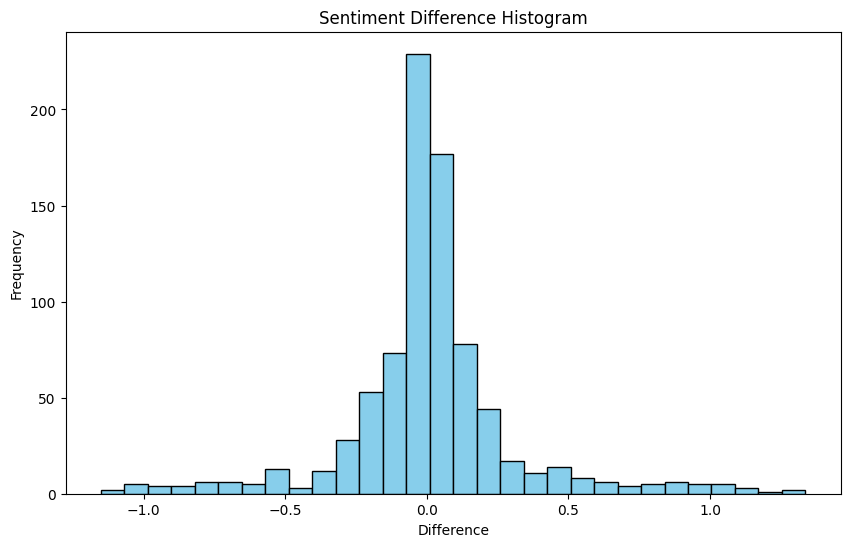

In [26]:
diff=y_test-y_pred_flat

plt.figure(figsize=(10, 6))
plt.hist(diff, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Sentiment Difference Histogram')
plt.show()

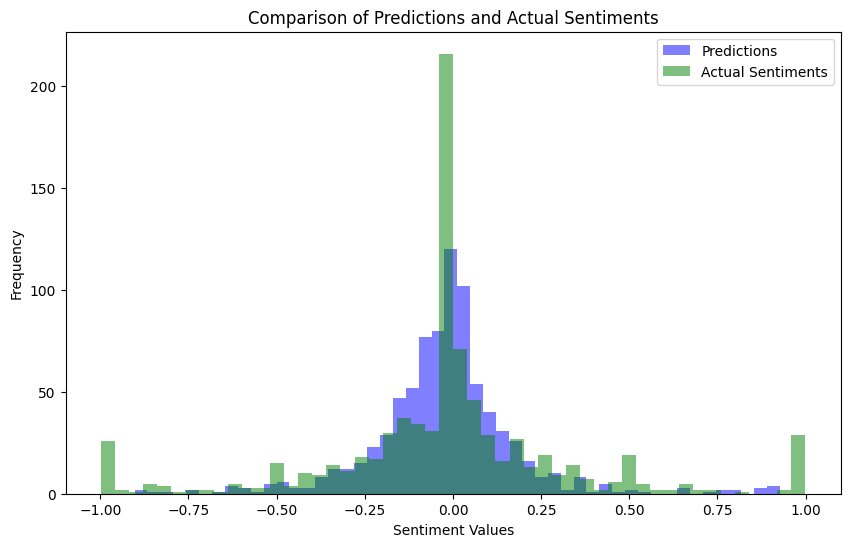

In [27]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=50, alpha=0.5, color='blue', label='Predictions')
plt.hist(y_test, bins=50, alpha=0.5, color='green', label='Actual Sentiments')
plt.title('Comparison of Predictions and Actual Sentiments')
plt.xlabel('Sentiment Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [28]:
X_test_texts = test_data["TEXT"].squeeze().tolist()

X_test_tfidf = tfidf_vectorizer.transform(X_test_texts)
X_test_array = np.array(X_test_tfidf.toarray())


test_data["SENTIMENT_PRED"] = model.predict(X_test_array)

519/519 [==============================] - 1s 2ms/step


/var/folders/4h/c_6klx0d0bd723smcqr1l_3h0000gn/T/ipykernel_57736/1682832686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["SENTIMENT_PRED"] = model.predict(X_test_array)


In [29]:
test_data[["SENTIMENT", "SENTIMENT_PRED"]]

,SENTIMENT,SENTIMENT_PRED
4145,-0.126703,-0.049179
4146,-0.496367,-0.091316
4147,-0.345116,-0.133110
4148,0.993337,0.567322
4149,-0.249648,0.094498
...,...,...
20723,0.489600,-0.084458
20724,0.084893,-0.083347
20725,-0.000143,-0.010657
20726,0.251992,0.087429


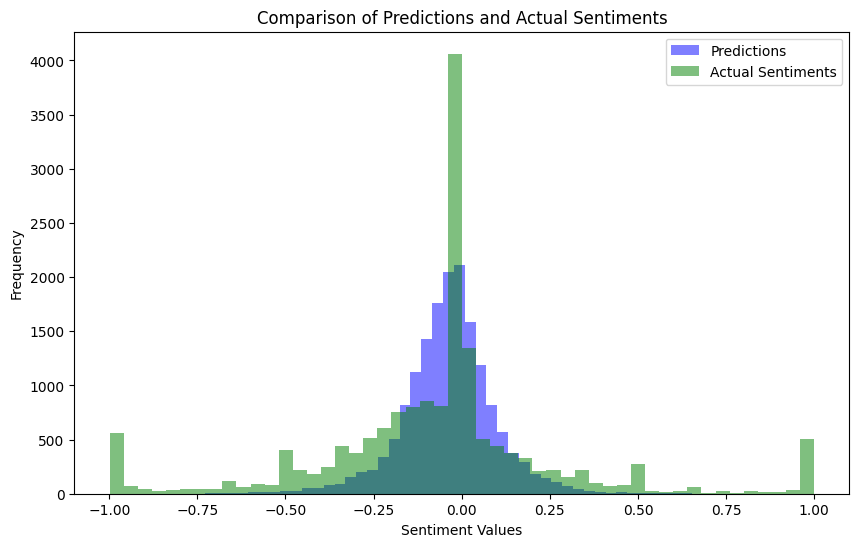

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(test_data["SENTIMENT_PRED"], bins=50, alpha=0.5, color='blue', label='Predictions')
plt.hist(test_data["SENTIMENT"], bins=50, alpha=0.5, color='green', label='Actual Sentiments')
plt.title('Comparison of Predictions and Actual Sentiments')
plt.xlabel('Sentiment Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

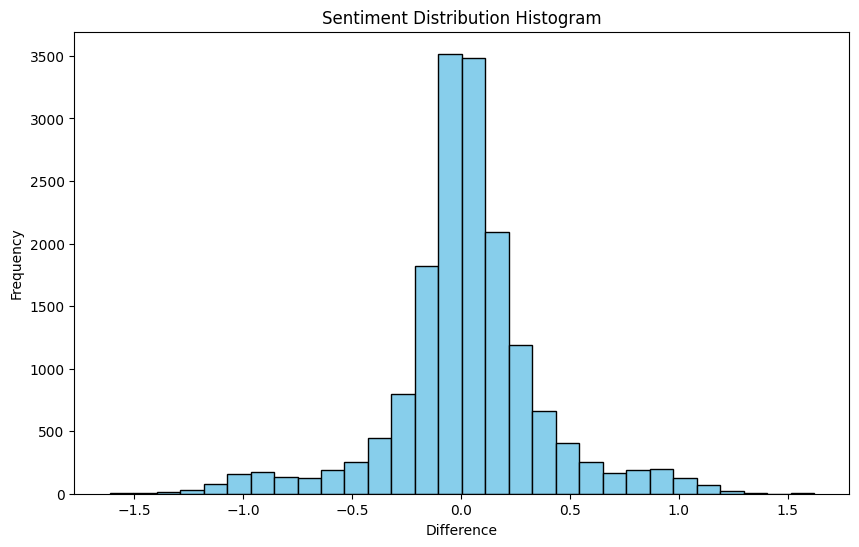

In [31]:
diff=test_data["SENTIMENT_PRED"]-test_data["SENTIMENT"]

plt.figure(figsize=(10, 6))
plt.hist(diff, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Histogram')
plt.show()

In [32]:
train_data["SENTIMENT_PRED"] = train_data["SENTIMENT"]
data = pd.concat([train_data, test_data], ignore_index=True)

/var/folders/4h/c_6klx0d0bd723smcqr1l_3h0000gn/T/ipykernel_57736/1299715006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["SENTIMENT_PRED"] = train_data["SENTIMENT"]


In [33]:
data

,DATE,OUTLET,AUTHOR,DESCRIPTION,TEXT,SENTIMENT,SENTIMENT_PRED
0,2022-01-01,washington post,Taylor Telford Rachel Siegel,NaN,"Copyright 2022, The Washington Post Co. All Ri...",0.999708,0.999708
1,2022-01-01,washington post,Christian Davenport,NaN,\nIf 2021 was the year of the private space to...,0.349015,0.349015
2,2022-01-01,guardian,Catherine Bennett,NaN,“What was needed (someone might argue) was not...,-0.000056,-0.000056
3,2022-01-01,WSJ,Paul Vigna,NaN,"Elon Musk tweeted about it, often. Coinbase Gl...",-0.000008,-0.000008
4,2022-01-01,google,twitter,"Jan 27, 2022 ... Log in · Sign up. See new pos...",Please enable JavaScript or switch to a suppor...,-0.000016,-0.000016
...,...,...,...,...,...,...,...
20723,2023-11-15,NYT,"Andrew Ross Sorkin, Bernhard Warner, Sarah Kes...",NaN,A better-than-expected Consumer Price Index re...,0.489600,-0.084458
20724,2023-11-15,business insider,gkay@insider.com (Grace Kay),NaN,\n* Elon Musk has promoted his truck as toughe...,0.084893,-0.083347
20725,2023-11-15,washington post,By,NaN,\nFord was known for his rabidly antisemitic h...,-0.000143,-0.010657
20726,2023-11-16,barrons,Al Root,NaN,SpaceX[https://www-barrons-com.gate3.library.l...,0.251992,0.087429


In [34]:
average_sentiment = data.groupby(data["DATE"].dt.to_period("D"))["SENTIMENT"].mean().reset_index()
average_sentiment_pred = data.groupby(data["DATE"].dt.to_period("D"))["SENTIMENT_PRED"].mean().reset_index()

average_sentiment["DATE"] = average_sentiment["DATE"].astype(str)
average_sentiment_pred["DATE"] = average_sentiment_pred["DATE"].astype(str)

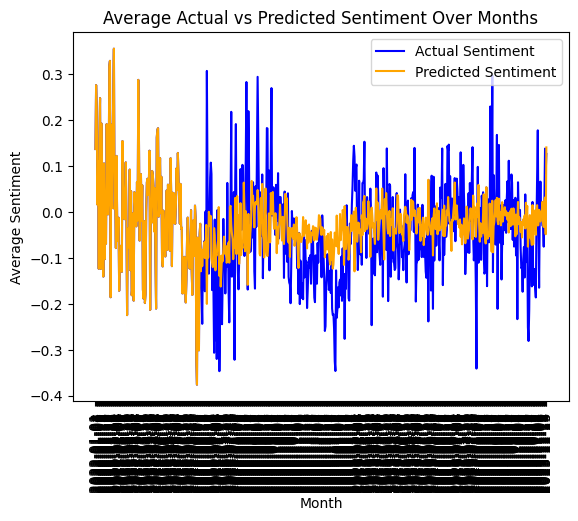

In [35]:
plt.plot(average_sentiment["DATE"], average_sentiment["SENTIMENT"], label="Actual Sentiment", color='blue')
plt.plot(average_sentiment_pred["DATE"], average_sentiment_pred["SENTIMENT_PRED"], label="Predicted Sentiment", color='orange')

plt.xlabel("Month")
plt.ylabel("Average Sentiment")
plt.title("Average Actual vs Predicted Sentiment Over Months")

plt.xticks(rotation='vertical')
plt.legend()

plt.show()

In [36]:
average_sentiment = data.groupby(data["DATE"].dt.to_period("M"))["SENTIMENT"].mean().reset_index()
average_sentiment_pred = data.groupby(data["DATE"].dt.to_period("M"))["SENTIMENT_PRED"].mean().reset_index()

average_sentiment["DATE"] = average_sentiment["DATE"].astype(str)
average_sentiment_pred["DATE"] = average_sentiment_pred["DATE"].astype(str)

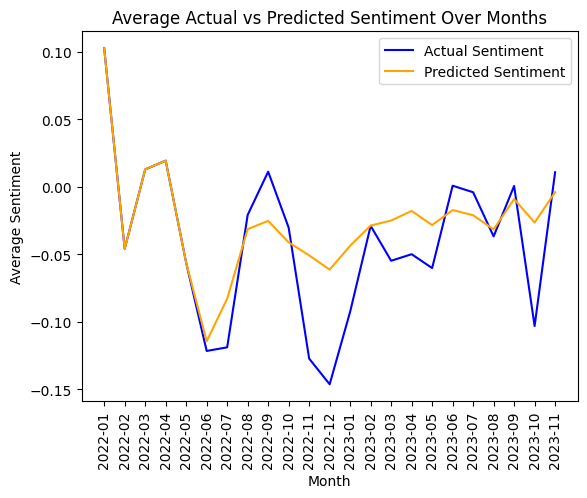

In [37]:
plt.plot(average_sentiment["DATE"], average_sentiment["SENTIMENT"], label="Actual Sentiment", color='blue')
plt.plot(average_sentiment_pred["DATE"], average_sentiment_pred["SENTIMENT_PRED"], label="Predicted Sentiment", color='orange')

plt.xlabel("Month")
plt.ylabel("Average Sentiment")
plt.title("Average Actual vs Predicted Sentiment Over Months")

plt.xticks(rotation='vertical')
plt.legend()

plt.show()

In [38]:
average_sentiment_week = data.groupby(data["DATE"].dt.to_period("W"))["SENTIMENT"].mean().reset_index()
average_sentiment_pred_week = data.groupby(data["DATE"].dt.to_period("W"))["SENTIMENT_PRED"].mean().reset_index()

average_sentiment_week["DATE"] = average_sentiment_week["DATE"].astype(str)
average_sentiment_pred_week["DATE"] = average_sentiment_pred_week["DATE"].astype(str)

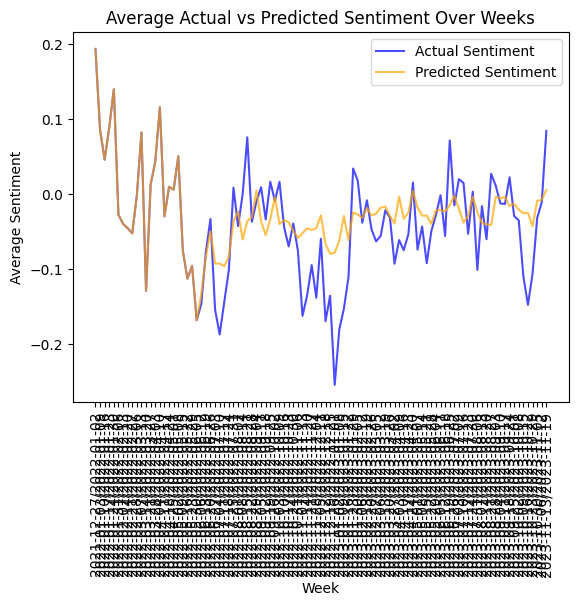

In [39]:
plt.plot(average_sentiment_week["DATE"], average_sentiment_week["SENTIMENT"], label="Actual Sentiment", color='blue', alpha=0.7)
plt.plot(average_sentiment_pred_week["DATE"], average_sentiment_pred_week["SENTIMENT_PRED"], label="Predicted Sentiment", color='orange', alpha=0.7)

plt.xlabel("Week")
plt.ylabel("Average Sentiment")
plt.title("Average Actual vs Predicted Sentiment Over Weeks")

plt.xticks(rotation='vertical')
plt.legend()

plt.show()